In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", "..", ".."))

# Grid to network hotspotting

Here we produce a grid based hotspot map and then push down to a network.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import descartes

import open_cp.sources.chicago
import open_cp.geometry
import open_cp.prohotspot
import open_cp.predictors
import open_cp.network
import open_cp.evaluation

In [3]:
data_path = os.path.join("/media", "disk", "Data")
#data_path = os.path.join("..", "..", "..", "..", "..", "..", "Data")
open_cp.sources.chicago.set_data_directory(data_path)
south_side = open_cp.sources.chicago.get_side("South")

In [4]:
grid = open_cp.data.Grid(xsize=150, ysize=150, xoffset=0, yoffset=0)
grid = open_cp.geometry.mask_grid_by_intersection(south_side, grid)

In [5]:
filename = open_cp.sources.chicago.get_default_filename()
timed_points = open_cp.sources.chicago.load(filename, ["BURGLARY"])
timed_points.number_data_points, timed_points.time_range

(13970,
 (numpy.datetime64('2016-05-04T05:30:00.000'),
  numpy.datetime64('2017-05-03T23:48:00.000')))

In [6]:
timed_points = open_cp.geometry.intersect_timed_points(timed_points, south_side)
timed_points.number_data_points

1985

In [7]:
predictor = open_cp.prohotspot.ProspectiveHotSpot(grid=grid)
predictor.data = timed_points
tend = np.datetime64("2016-08-01")
prediction = predictor.predict(tend, tend)
prediction.mask_with(grid)

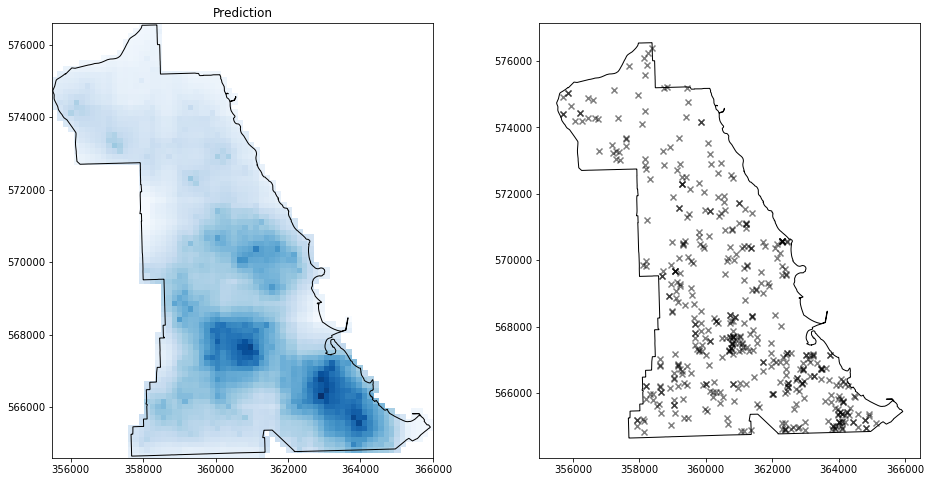

In [8]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.set_aspect(1)
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
ax[0].pcolormesh(*prediction.mesh_data(), prediction.intensity_matrix, cmap="Blues")
ax[0].set_title("Prediction")

points = predictor.data.events_before(tend)
ax[1].scatter(points.xcoords, points.ycoords, marker="x", color="black", alpha=0.5)
None

# Convert to a network

In [9]:
with open("input.graph", "rb") as f:
    graph = open_cp.network.PlanarGraph.from_bytes(f.read())

In [10]:
_,_,risks = open_cp.evaluation.grid_risk_to_graph(prediction, graph)

In [11]:
_cdict = {'red':   [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],
         'green': [(0.0,  1.0, 1.0),
                   (1.0,  0.0, 0.0)],
         'blue':  [(0.0,  0.2, 0.2),
                   (1.0,  0.2, 0.2)]}
yellow_to_red = matplotlib.colors.LinearSegmentedColormap("yellow_to_red", _cdict)

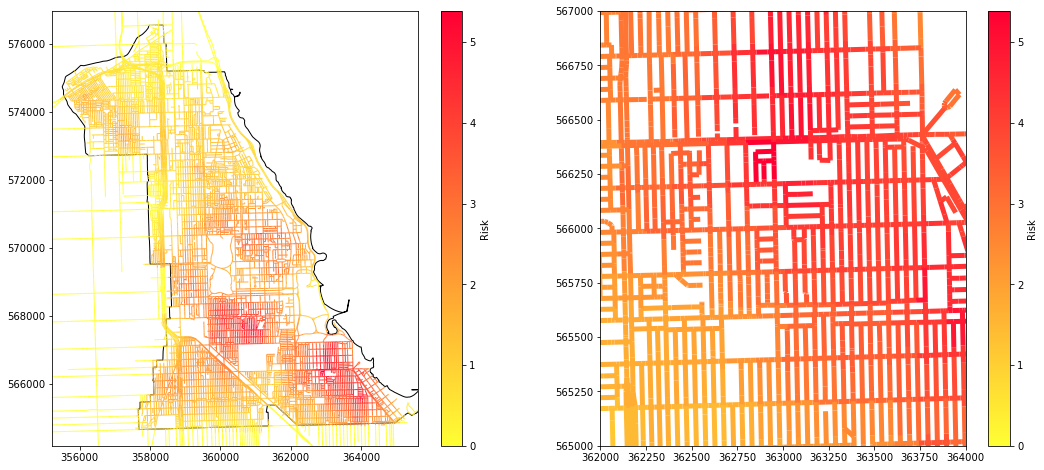

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax, lw in zip(axes, [1,5]):
    ax.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
    lc = matplotlib.collections.LineCollection(graph.as_lines(), linewidth=lw, cmap=yellow_to_red)
    lc.set_array(risks)
    ax.add_collection(lc)

    cbar = fig.colorbar(lc, orientation="vertical", ax=ax)
    cbar.set_label("Risk")

xmin, ymin, xmax, ymax = *timed_points.bounding_box.min, *timed_points.bounding_box.max
xd, yd = xmax - xmin, ymax - ymin
axes[0].set(xlim=(xmin-xd/20, xmax+xd/20), ylim=(ymin-yd/20, ymax+yd/20))
axes[1].set(xlim=[362000, 364000], ylim=[565000, 567000])
None

# Take 10% coverage by network length

In [13]:
mask = open_cp.evaluation.network_coverage(graph, risks, 0.1)

In [17]:
# Check we get about 10%
sum(graph.lengths), sum(graph.lengths[mask]), sum(graph.lengths[mask]) / sum(graph.lengths) * 100

(1443127.2144894777, 144271.75932452077, 9.9971615721735603)

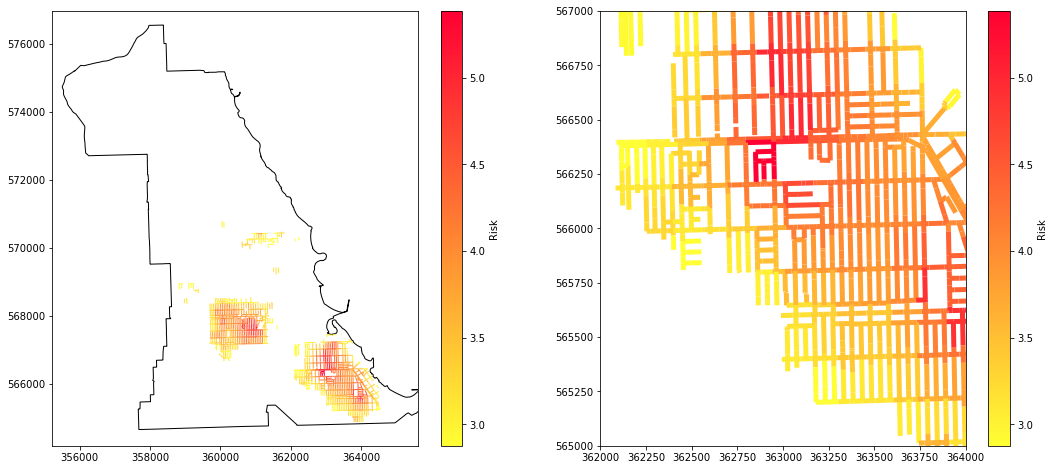

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax, lw in zip(axes, [1,5]):
    ax.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    
    lines = np.asarray(graph.as_lines())
    lc = matplotlib.collections.LineCollection(lines[mask], linewidth=lw, cmap=yellow_to_red)
    lc.set_array(risks[mask])
    ax.add_collection(lc)

    cbar = fig.colorbar(lc, orientation="vertical", ax=ax)
    cbar.set_label("Risk")

xmin, ymin, xmax, ymax = *timed_points.bounding_box.min, *timed_points.bounding_box.max
xd, yd = xmax - xmin, ymax - ymin
axes[0].set(xlim=(xmin-xd/20, xmax+xd/20), ylim=(ymin-yd/20, ymax+yd/20))
axes[1].set(xlim=[362000, 364000], ylim=[565000, 567000])
None